In [1]:
import pinns

# For cleaner output.
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
import torch
import torch.nn as nn

import numpy as np 

import matplotlib.pyplot as plt

import time

from pinns import Trainer
from pinns.models import FF, KAN
from pinns.errors import l2
from pinns.optimizers import Adam
from pinns.derivatives import Derivative
from pinns.samplers import RandomSampler, ConstantSampler, DataSampler

from prettytable import PrettyTable

---
## Damped Harmonic Oscillator

In [3]:
from scipy.integrate import solve_ivp

def dho(t, y, zeta, omega):
    x, v = y
    dxdt = v
    dvdt = -2 * zeta * omega * v - omega**2 * x
    return [dxdt, dvdt]

T = 10              # We need to fix some computational domain.
p = (0.2, 2.0)      # Parameters that yields interesting function.
x0, v0 = 5.0, 7.0   # Initial values may be arbitrary.

t = torch.linspace(0, T, 128)
solution = solve_ivp(dho, (0, T), (x0, v0), t_eval=t, args=p).y[0]

In [4]:
from pinns.samplers import ConstantSampler, RandomSampler

# Constraints (training data) sampler must return tuple (points, values).
constraints_sampler = ConstantSampler((
    torch.tensor([[0.]], requires_grad=True),
    torch.tensor([x0, v0])
))

# Collocation sampler must return just tensor of shape [num_pts, coords].
domain = {'t': [0, T]}
collocation_sampler = RandomSampler(domain, 256, return_dict=False)

# Test points sampler must return tuple (points, values) of shape [num_pts, coords].
test_points_sampler = ConstantSampler(
    (t.reshape(-1, 1), solution.reshape(-1, 1))
    )

In [5]:
d = Derivative(method = 'autograd')

def loss(
    cstr_pts, cstr_pred, cstr_vals,
    coll_pts, coll_pred,
    zeta = 0.2, omega = 2.0
    ):
    
    def init_loss(x0, t0):
        v0 = d(x0, t0)
        return torch.mean(torch.square(torch.hstack([x0, v0]) - cstr_vals))

    def ode_loss(x, t):
        v, a = d(x, t, orders = [1, 2])
        return torch.mean(torch.square(a + 2 * zeta * omega * v + omega**2 * x))
    
    losses = (
        init_loss(cstr_pred, cstr_pts),
        ode_loss(coll_pred, coll_pts)
    )
    
    return losses

In [6]:
def train(pinn, lr = 1e-2, iterations = 1500, loss_coefs = [0.8, 0.2]):
    
    adam = Adam(pinn, lr = lr)

    trainer = Trainer(
        loss,
        pinn,
        constraints_sampler,
        collocation_sampler,
        loss_coefs=loss_coefs,    # Coefficients are very important.
        test_points_sampler=test_points_sampler
    )
    
    start = time.time()

    trainer.train(
        num_iters=iterations,
        optimizers=[(0, adam)],
        # validate_every=1
    )
    
    end = time.time()
    
    error = trainer.evaluate(l2)
    print(f'Error is {error:.5f}')
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 3))

    axs[0].plot(trainer.loss_history, label='Loss')
    axs[0].plot(trainer.error_history, label='L2')
    axs[0].grid()
    axs[0].set_yscale('log')
    axs[0].legend()

    preds = pinn.predict(t.reshape(-1, 1))
    axs[1].plot(t, solution, label='Solution')
    axs[1].plot(t, preds.detach(), label='Predicts', linestyle=':')
    axs[1].grid()
    axs[1].legend()

    plt.show()
    
    return error, trainer.loss_history, end - start

In [7]:
dho_results = {}

  0%|          | 0/1500 [00:00<?, ?it/s]

Error is 2.10205


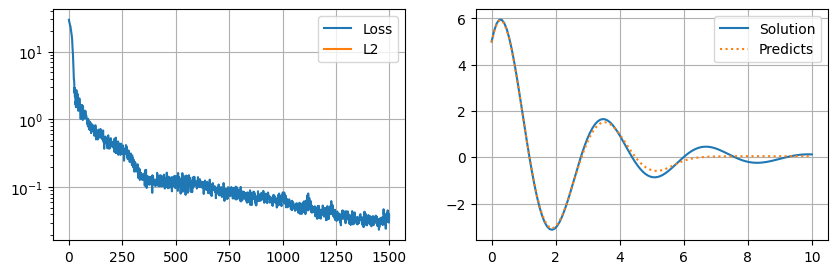

In [8]:
name = 'mlp'

pinn = FF([1, 32, 32, 1], activ=nn.Tanh())
error, loss_history, elapsed = train(pinn, lr = 1e-2)
dho_results[name] = [error, loss_history, elapsed]

  0%|          | 0/1500 [00:00<?, ?it/s]

Error is 0.89283


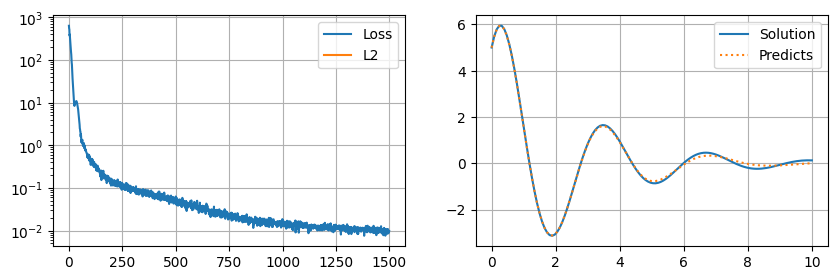

In [9]:
name = 'bsplines'

pinn = KAN([1, 10, 1], type = name, grid = 5)
error, loss_history, elapsed = train(pinn, lr = 1e-2)
dho_results[name] = [error, loss_history, elapsed]

  0%|          | 0/1500 [00:00<?, ?it/s]

Error is 0.74235


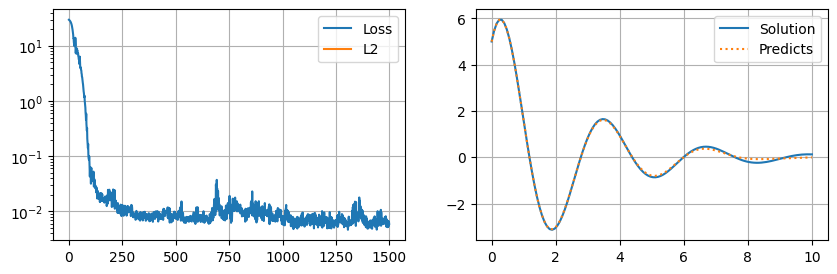

In [10]:
name = 'efficient'

pinn = KAN([1, 10, 1], type = name, grid_size = 10)
error, loss_history, elapsed = train(pinn, lr = 1e-2)
dho_results[name] = [error, loss_history, elapsed]

  0%|          | 0/1500 [00:00<?, ?it/s]

Error is 1.68017


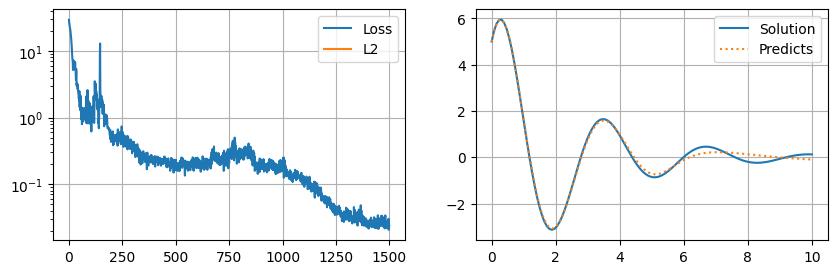

In [11]:
name = 'fast'

pinn = KAN([1, 10, 1], type = name, num_grids = 5)
error, loss_history, elapsed = train(pinn, lr = 1e-2)
dho_results[name] = [error, loss_history, elapsed]

In [12]:
# name = 'faster'

# pinn = KAN([1, 10, 1], type = name, num_grids = 5)
# error, loss_history, elapsed = train(pinn, lr = 1e-2)
# dho_results[name] = [error, loss_history, elapsed]

  0%|          | 0/1500 [00:00<?, ?it/s]

Error is 12.61148


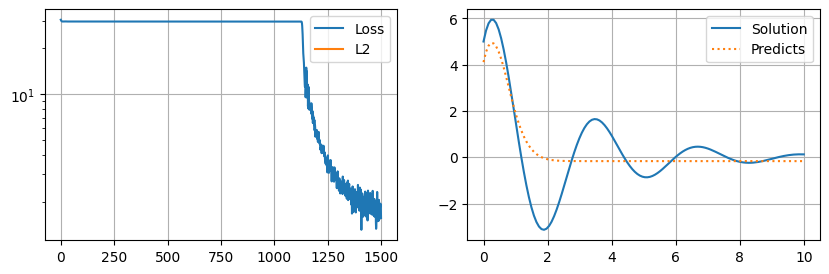

In [13]:
name = 'rbf'

pinn = KAN([1, 10, 1], type = name, num_centers = 5)
error, loss_history, elapsed = train(pinn, lr = 1e-2)
dho_results[name] = [error, loss_history, elapsed]

  0%|          | 0/1500 [00:00<?, ?it/s]

Error is 17.47385


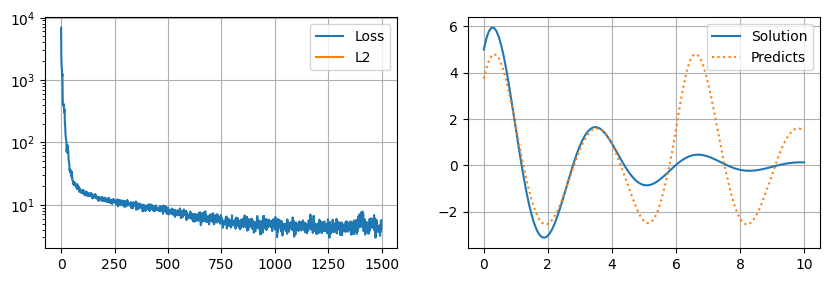

In [14]:
name = 'fourier'

pinn = KAN([1, 10, 1], type = name, gridsize = 5)
error, loss_history, elapsed = train(pinn, lr = 1e-2)
dho_results[name] = [error, loss_history, elapsed]

  0%|          | 0/1500 [00:00<?, ?it/s]

Error is 1.38299


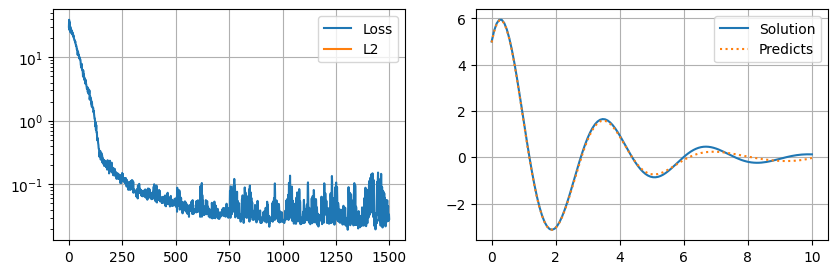

In [15]:
name = 'chebyshev'

pinn = KAN([1, 10, 1], type = name, scale = T, degree = 4)
error, loss_history, elapsed = train(pinn, lr = 1e-2)
dho_results[name] = [error, loss_history, elapsed]

In [16]:
table = PrettyTable(['Name', 'Error', 'Time'])

for name, (error, _, elapsed) in dho_results.items():
    table.add_row([name, np.round(error, decimals=2), np.round(elapsed, decimals=1)])

table.sortby = 'Error'
print(table)

+-----------+-------+-------+
|    Name   | Error |  Time |
+-----------+-------+-------+
| efficient |  0.74 |  76.3 |
|  bsplines |  0.89 | 173.6 |
| chebyshev |  1.38 |  35.4 |
|    fast   |  1.68 |  36.2 |
|    mlp    |  2.1  |  15.3 |
|    rbf    | 12.61 |  33.2 |
|  fourier  | 17.47 |  34.9 |
+-----------+-------+-------+


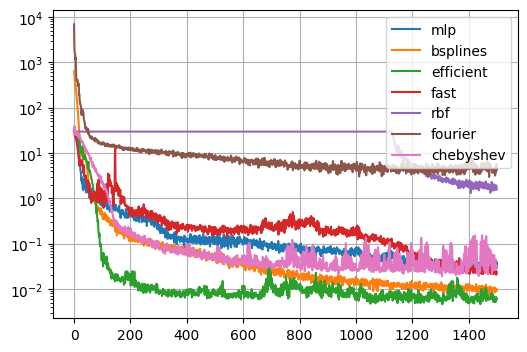

In [17]:
fig = plt.figure(figsize=(6, 4))
for name, (_, loss_history, _) in dho_results.items():
    plt.plot(loss_history, label = name)
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

---
## Diffusion 1D

In [18]:
path = './examples/diff1d/'

def get_data(path):
    init = torch.tensor(np.load(path + 'init_data.npy'))
    left = torch.tensor(np.load(path + 'left_data.npy'))
    right = torch.tensor(np.load(path + 'right_data.npy'))
    
    return ([init[:,  :2], left[:,  :2], right[:,  :2]], 
            [init[:, [2]], left[:, [2]], right[:, [2]]])

pts, data = get_data(path)
constraints_sampler = ConstantSampler((pts, data))

domain = {'t': [0, 0.5], 'x': [0, 1]}
collocation_sampler = RandomSampler(domain, 2048, return_dict=True)

test_data_sampler = DataSampler(path + 'solution.npy', 1024, 2)

In [19]:
d = Derivative(method='autograd')

def loss(
    cstr_pts, cstr_pred, cstr_vals,
    coll_pts, coll_pred,
    D = 0.5
    ):
    
    # We do not need left and right because we are solving 
    # Dirichlet problem and we just compare predictions and 
    # solution. If we solve Cauchy or Robin problem, we 
    # need to calculate derivatives at boundary points.
    
    init_pts, left_pts, right_pts = cstr_pts
    init_pred, left_pred, right_pred = cstr_pred
    init_vals, left_vals, right_vals = cstr_vals
    
    # If we use RandomSampler, we are unable to split values
    # like that. But it is just for clarity.
    
    t, x = coll_pts['t'], coll_pts['x']
    
    def initial_loss():
        return torch.mean(torch.square(init_pred - init_vals))
    
    def left_loss():
        return torch.mean(torch.square(left_pred - left_vals))
    
    def right_loss():
        return torch.mean(torch.square(right_pred - right_vals))
    
    def pde_loss(u, t, x):
        ut  = d(u,  t)
        uxx = d(u,  x, orders = 2)
        
        return torch.mean(torch.square(ut - D * uxx))
    
    return (
        initial_loss(), 
        left_loss(), 
        right_loss(), 
        pde_loss(coll_pred, t, x)
    )

In [20]:
Nt, Nx = 500, 750
pts, values = test_data_sampler(full=True)

pts = [
    pts[:,0].reshape(Nx, Nt),
    pts[:,1].reshape(Nx, Nt)
]
values = values.reshape(Nx, Nt)

cstr_pts, cstr_vals = constraints_sampler()
stacked_pts = torch.cat([torch.hstack([t[:, [1]], t[:, [0]]]) for t in cstr_pts])
stacked_vals = torch.cat(cstr_vals)
constraints = torch.hstack([stacked_pts, stacked_vals.reshape(-1, 1)]).T

def train(pinn, lr = 1e-2, iterations = 1500, loss_coefs = [0.75, 0.75, 0.75, 0.25]):
    
    adam = Adam(pinn, lr = lr)

    trainer = Trainer(
        loss,
        pinn,
        constraints_sampler,
        collocation_sampler,
        loss_coefs=loss_coefs,    # Coefficients are very important.
        test_points_sampler=test_data_sampler
    )
    
    start = time.time()

    trainer.train(
        num_iters=iterations,
        optimizers=[(0, adam)]
    )
    
    end = time.time()
    
    error = trainer.evaluate(l2, full = True)
    print(f'Error is {error:.5f}')
    
    fig = plt.figure(figsize=(12, 5))

    ax = fig.add_subplot(121)
    ax.plot(trainer.loss_history, label='Loss')
    # ax.plot(range(0, trainer.iter + 1, 1), trainer.error_history, label='Error')
    ax.grid()
    ax.set_yscale('log')
    ax.legend()

    preds = pinn.predict(test_data_sampler(full=True)[0]).detach().reshape(Nx, Nt)

    ax = fig.add_subplot(122, projection='3d')
    ax.plot_surface(pts[1], pts[0], preds, cmap='viridis')
    # ax.plot_surface(pts[1], pts[0], values, cmap='viridis')

    ax.scatter3D(*constraints, color='r', s=10)
    # ax.view_init(80, -120)

    plt.tight_layout()
    plt.show()
    
    return error, trainer.loss_history, end - start

In [21]:
diff_results = {}

  0%|          | 0/1500 [00:00<?, ?it/s]

Error is 12.67434


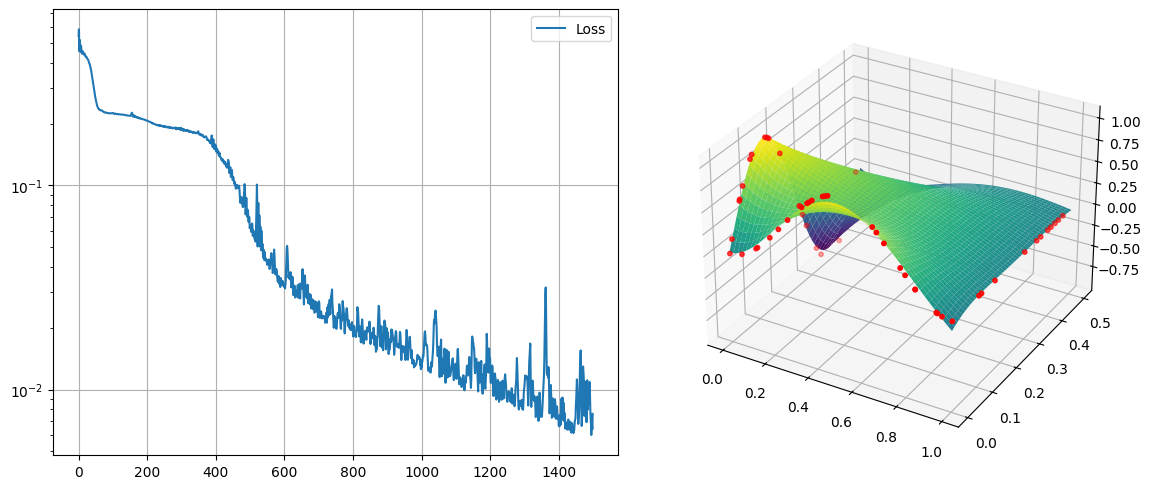

In [22]:
name = 'mlp'

pinn = FF([2, 32, 32, 1], activ=nn.Tanh())
error, loss_history, elapsed = train(pinn, lr = 1e-2)
diff_results[name] = [error, loss_history, elapsed]

  0%|          | 0/1500 [00:00<?, ?it/s]

Error is 8.30142


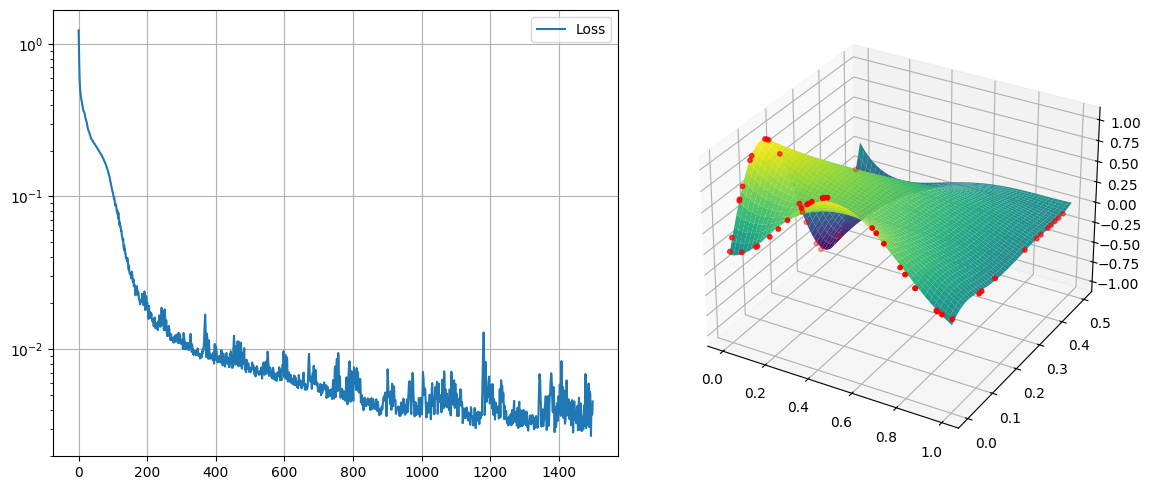

In [23]:
name = 'bsplines'

pinn = KAN([2, 10, 1], type = name, grid = 5)
error, loss_history, elapsed = train(pinn, lr = 1e-2)
diff_results[name] = [error, loss_history, elapsed]

  0%|          | 0/1500 [00:00<?, ?it/s]

Error is 5.12049


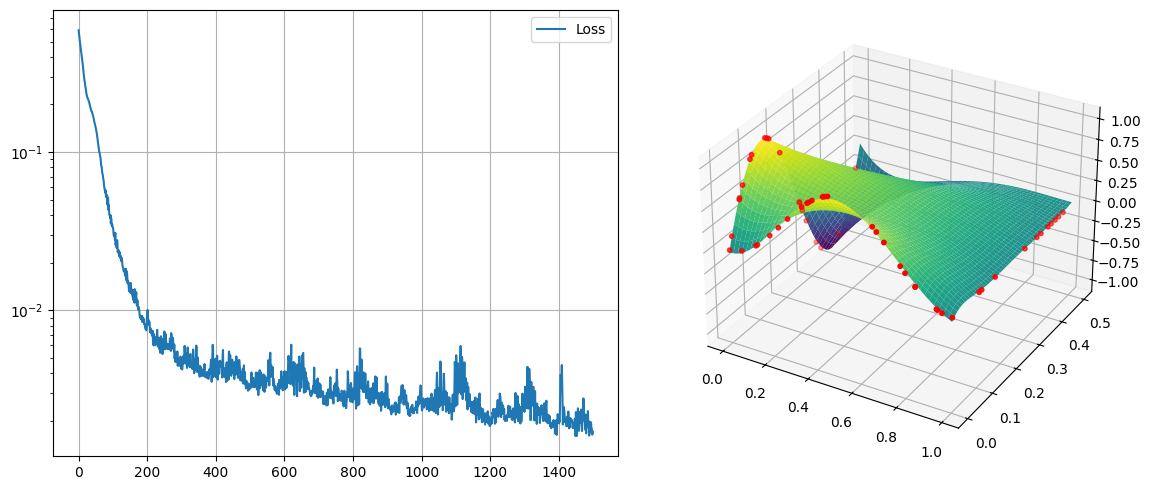

In [24]:
name = 'efficient'

pinn = KAN([2, 10, 1], type = name, grid_size = 10)
error, loss_history, elapsed = train(pinn, lr = 1e-2)
diff_results[name] = [error, loss_history, elapsed]

  0%|          | 0/1500 [00:00<?, ?it/s]

Error is 215.98991


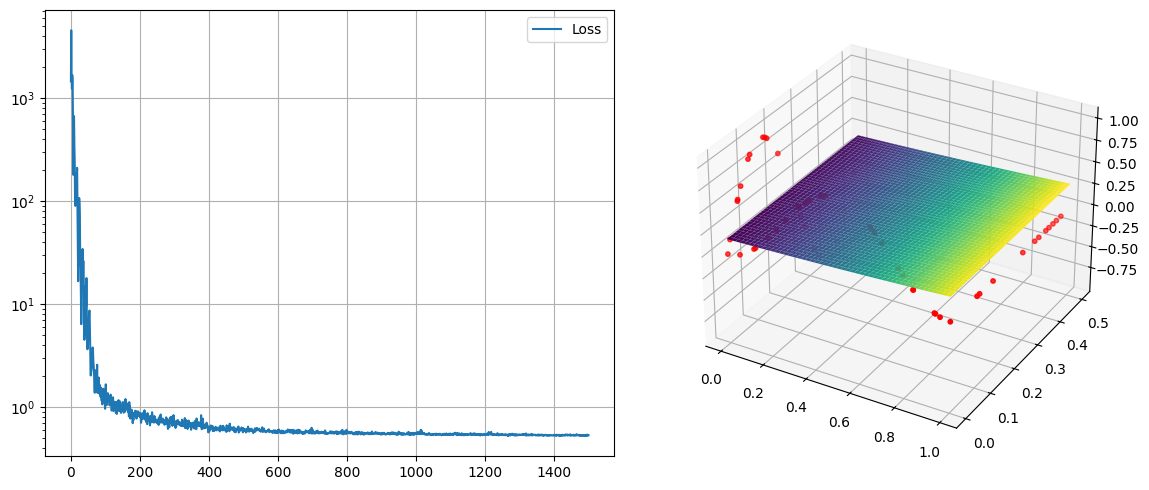

In [25]:
name = 'fast'

pinn = KAN([2, 10, 1], type = name, num_grids = 5)
error, loss_history, elapsed = train(pinn, lr = 1e-2)
diff_results[name] = [error, loss_history, elapsed]

  0%|          | 0/1500 [00:00<?, ?it/s]

Error is 210.14525


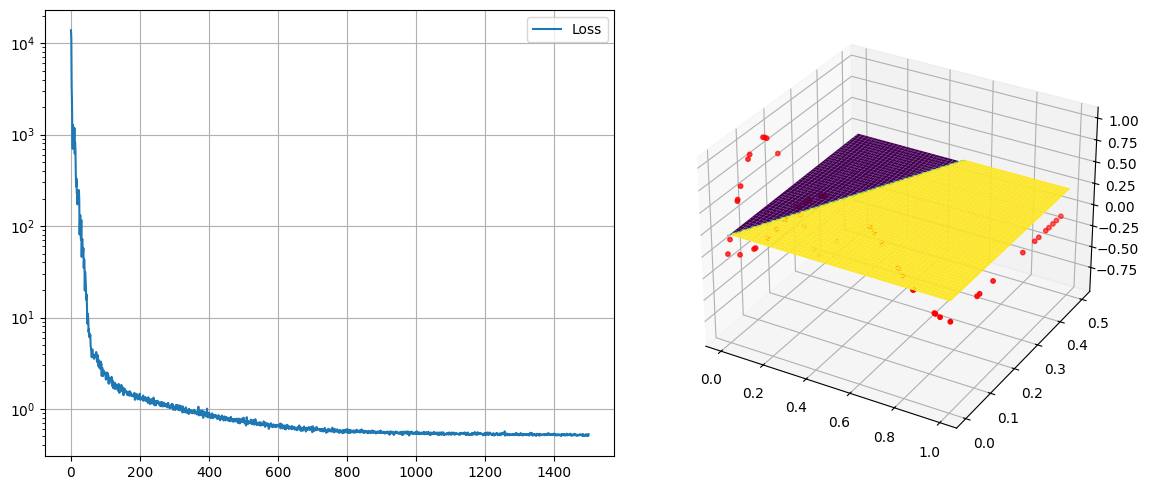

In [26]:
name = 'faster'

pinn = KAN([2, 10, 1], type = name, num_grids = 5)
error, loss_history, elapsed = train(pinn, lr = 1e-2)
diff_results[name] = [error, loss_history, elapsed]

  0%|          | 0/1500 [00:00<?, ?it/s]

Error is 34.34602


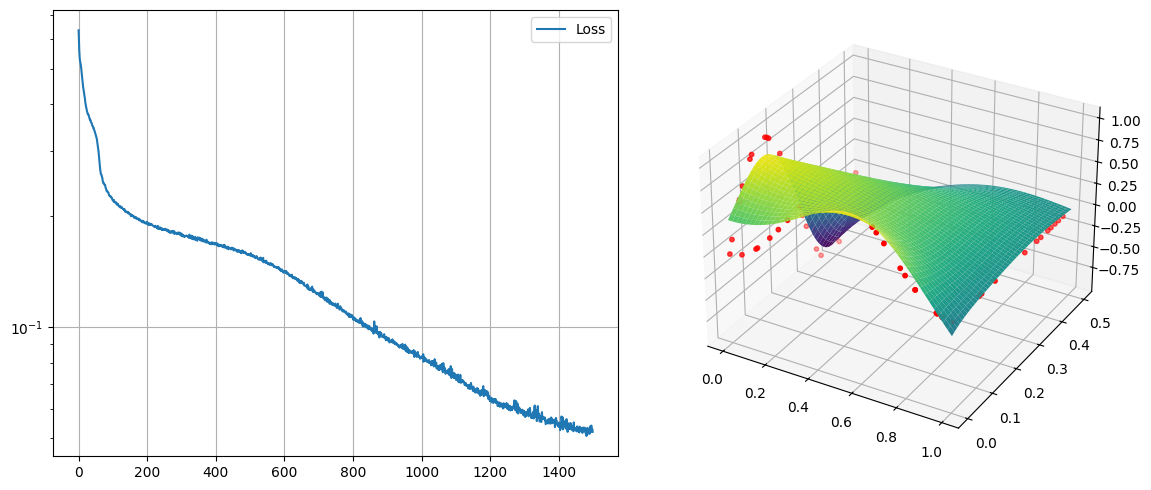

In [27]:
name = 'rbf'

pinn = KAN([2, 10, 1], type = name, num_centers = 5)
error, loss_history, elapsed = train(pinn, lr = 1e-2)
diff_results[name] = [error, loss_history, elapsed]

  0%|          | 0/1500 [00:00<?, ?it/s]

Error is 24.77282


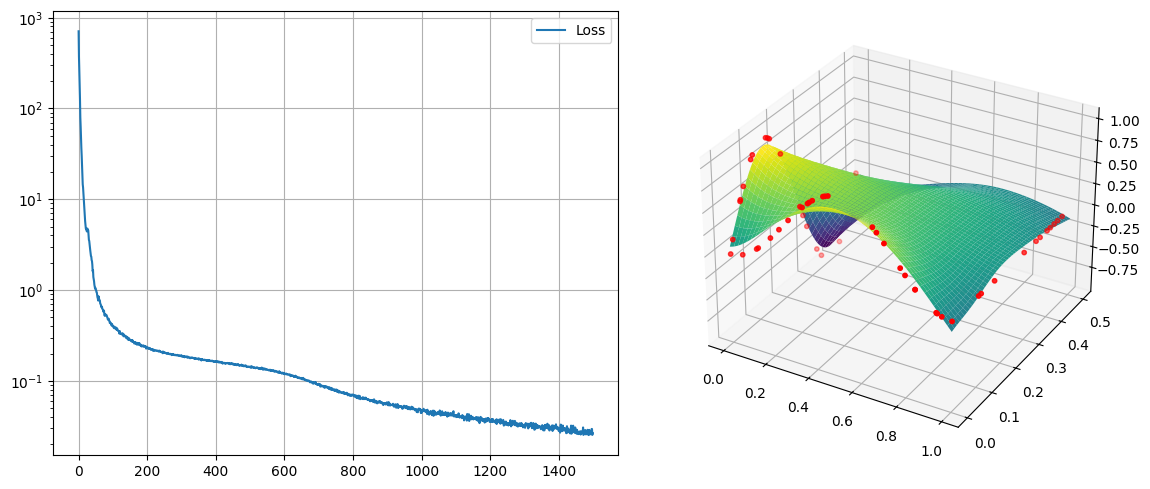

In [28]:
name = 'fourier'

pinn = KAN([2, 10, 1], type = name, gridsize = 5)
error, loss_history, elapsed = train(pinn, lr = 1e-2)
diff_results[name] = [error, loss_history, elapsed]

  0%|          | 0/1500 [00:00<?, ?it/s]

Error is 36.59802


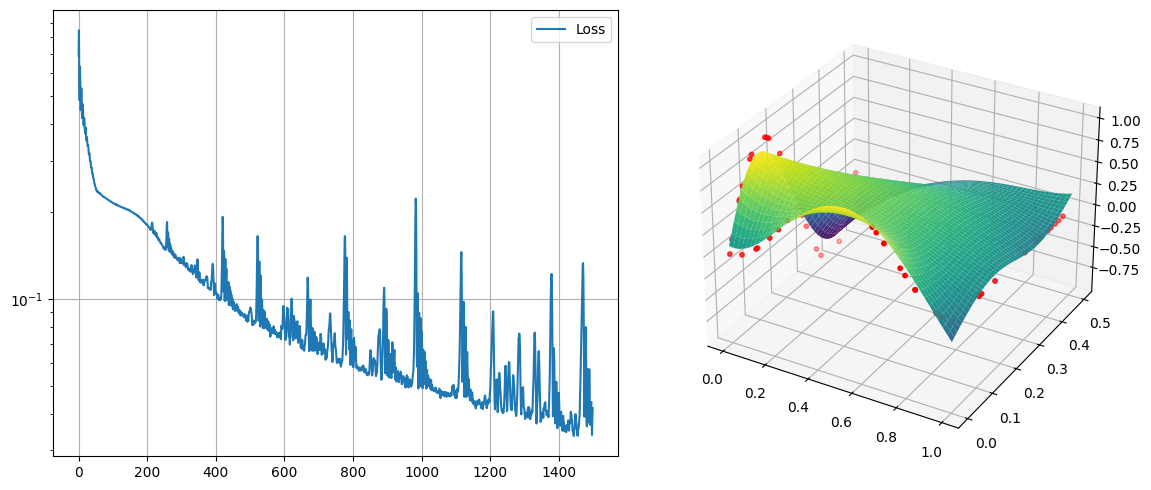

In [29]:
name = 'chebyshev'

pinn = KAN([2, 10, 1], type = name, scale = 2, degree = 4)
error, loss_history, elapsed = train(pinn, lr = 1e-2)
diff_results[name] = [error, loss_history, elapsed]

In [30]:
table = PrettyTable(['Name', 'Error', 'Time'])

for name, (error, _, elapsed) in diff_results.items():
    table.add_row([name, np.round(error, decimals=2), np.round(elapsed, decimals=1)])

table.sortby = 'Error'
print(table)

+-----------+--------+-------+
|    Name   | Error  |  Time |
+-----------+--------+-------+
| efficient |  5.12  | 214.8 |
|  bsplines |  8.3   | 497.4 |
|    mlp    | 12.67  |  33.2 |
|  fourier  | 24.77  |  98.9 |
|    rbf    | 34.35  |  68.7 |
| chebyshev |  36.6  | 105.6 |
|   faster  | 210.15 | 100.8 |
|    fast   | 215.99 | 116.1 |
+-----------+--------+-------+


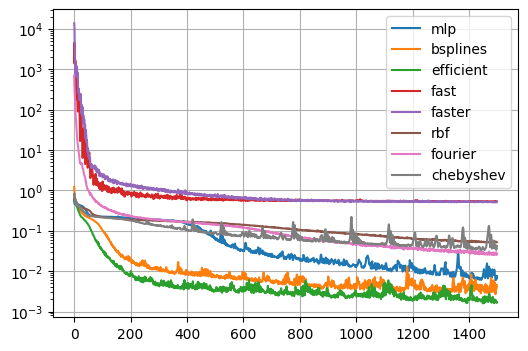

In [32]:
fig = plt.figure(figsize=(6, 4))
for name, (_, loss_history, _) in diff_results.items():
    plt.plot(loss_history, label = name)
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()